In [1]:
### From buoy data: compute tau from wind velocity & plot current velocity
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import cftime
import sys
import seawater as sw
import re
from metpy.calc import wind_components, density, specific_humidity_from_dewpoint, mixing_ratio_from_specific_humidity
from metpy.units import units
from oceans.ocfis import spdir2uv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from windstr import ra_windstr_nc

[datetime.datetime(2023, 1, 1, 0, 5) datetime.datetime(2023, 1, 1, 0, 35)
 datetime.datetime(2023, 1, 1, 1, 5)] [1800. 1800. 1800.] secconds


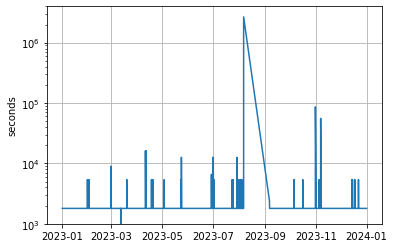

In [2]:
### buoy data info
year = '2023'
buoy_id = '42022'
path_data = '/Users/chi/Documents/Data/NDBC/'
fn_met = 'met_ndbc'+buoy_id+'_y'+year+'.txt'
fn_cur = 'current_ndbc'+buoy_id+'_y'+year+'.txt'

### read met data
arrayMet = np.genfromtxt(path_data+fn_met,skip_header=2)
arrayMet[arrayMet== 999] = np.nan
### convert to datetime
dtimeMet = []
for i in range( arrayMet.shape[0] ):
    dtimeMet.append( datetime.datetime(int(arrayMet[i,0]),int(arrayMet[i,1]),int(arrayMet[i,2]),int(arrayMet[i,3]),int(arrayMet[i,4])) )
dtimeMet = np.array( dtimeMet )

### the time intervals between measurements
### buoy 42022 is every 30 minutes. 
timestamp = np.array( [dtimeMet[i].timestamp() for i in range( len(dtimeMet) )] )
print(dtimeMet[0:3],np.diff(timestamp)[0:3],'secconds')
plt.semilogy( dtimeMet[:-1], np.diff(timestamp) )
plt.ylim([1e3,4e6])
plt.ylabel('seconds')
plt.grid()

Total Number of lines in the current data file: 6977
The caveat is that the file does not have exact same number of items in the header as in the data...
Shape of arrayCur: (6975, 125)
[datetime.datetime(2023, 1, 1, 0, 5) datetime.datetime(2023, 1, 1, 0, 35)
 datetime.datetime(2023, 1, 1, 1, 5)] [3600. 3600. 3600.] secconds
Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters: [42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25.
 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.
  6.  5.  4.  3.]


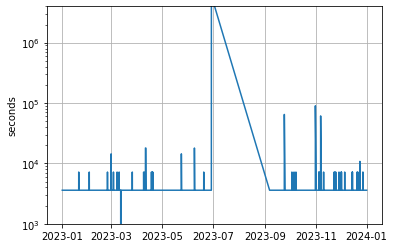

In [3]:
### read current data: there are some shorter entries for some lines
### get how many lines are in the file
nline_header = 2 ### need to check lines of headers manually
with open(path_data+fn_cur, 'r') as f:
    nrow = len(f.readlines())
    print('Total Number of lines in the current data file:', nrow)
### get the headers & number of items in the header
count = 0
print('The caveat is that the file does not have exact same number of items in the header as in the data...')
with open(path_data+fn_cur, 'r') as f:
    for line in f:
        if count == nline_header:
            line_1 = re.sub(r"\s+",',',line) ### replace space(s) with ','
            if line_1[-1] == ',':
                line_1 = line_1[:-1]
            break
        count = count + 1
### read through the file
line_1_list = line_1.split(',')
ncol = len(line_1_list) # number of items in the first line of data
arrayCur = np.nan*np.ones( (nrow-nline_header,ncol) ) ### record values only
count = 0
with open(path_data+fn_cur) as f:
    for line in f:
        count = count + 1
        line_1 = re.sub(r"\s+",',',line)
        if line_1[-1] == ',':
                line_1 = line_1[:-1]
        # print(line_1)
        if count > nline_header:
            temp = line_1.split(',')
            temp = [float(item) for item in temp]
            nitem = len(temp)
            arrayCur[count-nline_header-1,0:nitem] = np.array(temp)
        
print('Shape of arrayCur:',arrayCur.shape)
arrayCur[arrayCur == 999] = np.nan

### convert to datetime
dtimeCur = []
for i in range( arrayCur.shape[0] ):
    dtimeCur.append( datetime.datetime(int(arrayCur[i,0]),int(arrayCur[i,1]),int(arrayCur[i,2]),int(arrayCur[i,3]),int(arrayCur[i,4])) )
dtimeCur = np.array( dtimeCur )

### the time intervals between measurements
### buoy 42022 is every 30 minutes. 
timestamp = np.array( [dtimeCur[i].timestamp() for i in range( len(dtimeCur) )] )
print(dtimeMet[0:3],np.diff(timestamp)[0:3],'secconds')
plt.semilogy( dtimeCur[:-1], np.diff(timestamp) )
plt.ylim([1e3,4e6])
plt.ylabel('seconds')
plt.grid()

### depths of current
depths_cur = arrayCur[0,5:-1:3]
print('Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters:', depths_cur)

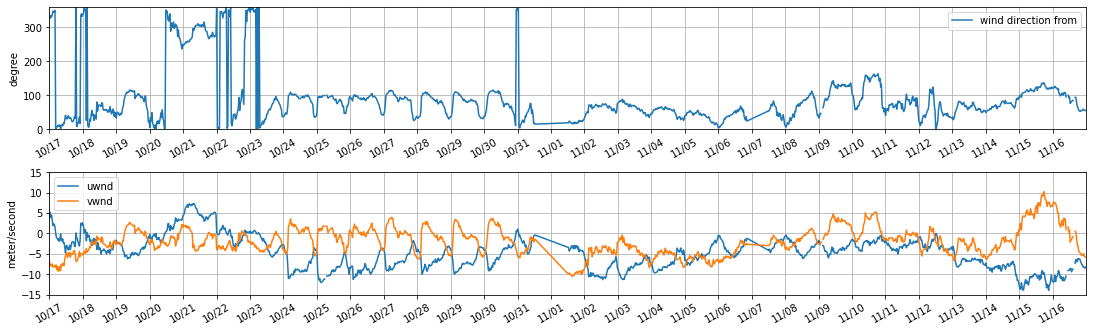

In [4]:
### convert to u & v wind components
uwnd, vwnd = wind_components(arrayMet[:,6]*units('m/s'),arrayMet[:,5]*units.deg)
### plot u/ v wind velcoity
tlim_plot = [datetime.datetime(int(year),10,17), datetime.datetime(int(year),11,17)]
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
###
nrow = 2
itmet = np.where( (dtimeMet>= tlim_plot[0]) & (dtimeMet< tlim_plot[1]) )[0]
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.subplot(nrow,1,1)
plt.plot(dtimeMet[itmet],arrayMet[itmet,5]*units.deg,label='wind direction from')
plt.ylim([0,360])
plt.subplot(nrow,1,2)
plt.plot(dtimeMet[itmet], uwnd[itmet],label='uwnd')
plt.plot(dtimeMet[itmet], vwnd[itmet],label='vwnd')
plt.ylim([-15,15])
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()
    plt.legend()
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
plt.savefig('timeseries_wind_ncbc-'+buoy_id+'_'+tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')\
            +'.png',dpi=300,bbox_inches='tight')

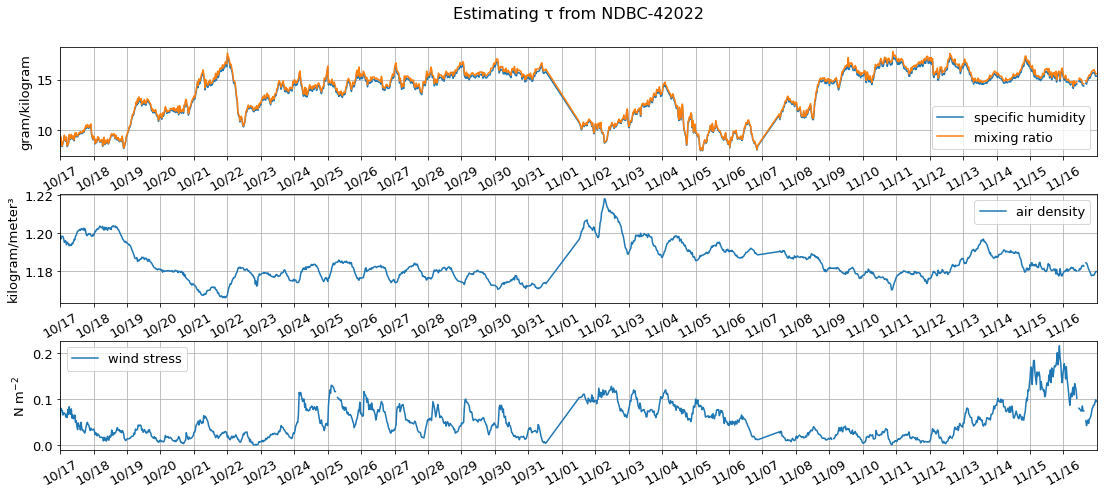

In [5]:
### compute air density (need specific humidity -> mixing ratio, air pressure), wind stress
sh = specific_humidity_from_dewpoint(arrayMet[:,12]*units.hPa,arrayMet[:,15]*units.degC).to('g/kg') # specific humidity
mixing_ratio = mixing_ratio_from_specific_humidity(sh).to('g/kg')
roh = density(arrayMet[:,12]*units.hPa, arrayMet[:,13]*units.degC, mixing_ratio)
taux, tauy = ra_windstr_nc(np.array(uwnd),np.array(vwnd),1.2)
tau = np.sqrt( np.square(taux)+ np.square(tauy) )
### plot
nrow = 3
itmet = np.where( (dtimeMet>= tlim_plot[0]) & (dtimeMet< tlim_plot[1]) )[0]
plt.clf()
plt.gcf().set_size_inches(18, 7)
plt.rcParams.update({'font.size': 13})
plt.subplot(nrow,1,1)
plt.plot(dtimeMet[itmet], sh[itmet],label='specific humidity')
plt.plot(dtimeMet[itmet],mixing_ratio[itmet],label='mixing ratio')
plt.subplot(nrow,1,2)
plt.plot(dtimeMet[itmet], roh[itmet],label='air density')
plt.subplot(nrow,1,3)
plt.plot(dtimeMet[itmet], tau[itmet], label='wind stress')
plt.ylabel('N m$^{-2}$')
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()
    plt.legend(loc='best')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
plt.suptitle('Estimating \N{GREEK SMALL LETTER TAU} from NDBC-'+buoy_id,fontsize=16)
### save figure
plt.savefig('timeseries_tau_ncbc-'+buoy_id+'_'+tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')\
            +'.png',dpi=300,bbox_inches='tight')

In [6]:
### compute u & v current velocity from speed (cm/s) and direction (flowing toward) from the current data
uCur = np.nan*np.ones( (arrayCur.shape[0],len(depths_cur)) )
vCur = uCur.copy()
i0dep = 5
i0dir = 6
i0spd = 7
for i in range( uCur.shape[0] ): ### time dimension
    for z in range( len(depths_cur) ): ### depth dimension
        spd_item = arrayCur[i,i0spd+z*3]
        dir_to_item = arrayCur[i,i0dir+z*3] # direction flowing toward
        dir_from_item = (dir_to_item+180)%360
        # print(spd_item, dir_from_item, dir_to_item)
        uCur[i,z], vCur[i,z] = spdir2uv( spd_item,dir_to_item,deg=True )
        # print(spd_item, dir_to_item, dir_from_item, uCur[i,z],vCur[i,z])
    #     break
    # break

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1865/1337061256.py:11: RuntimeWarning: invalid value encountered in double_scalars
  dir_from_item = (dir_to_item+180)%360


<Figure size 432x288 with 0 Axes>

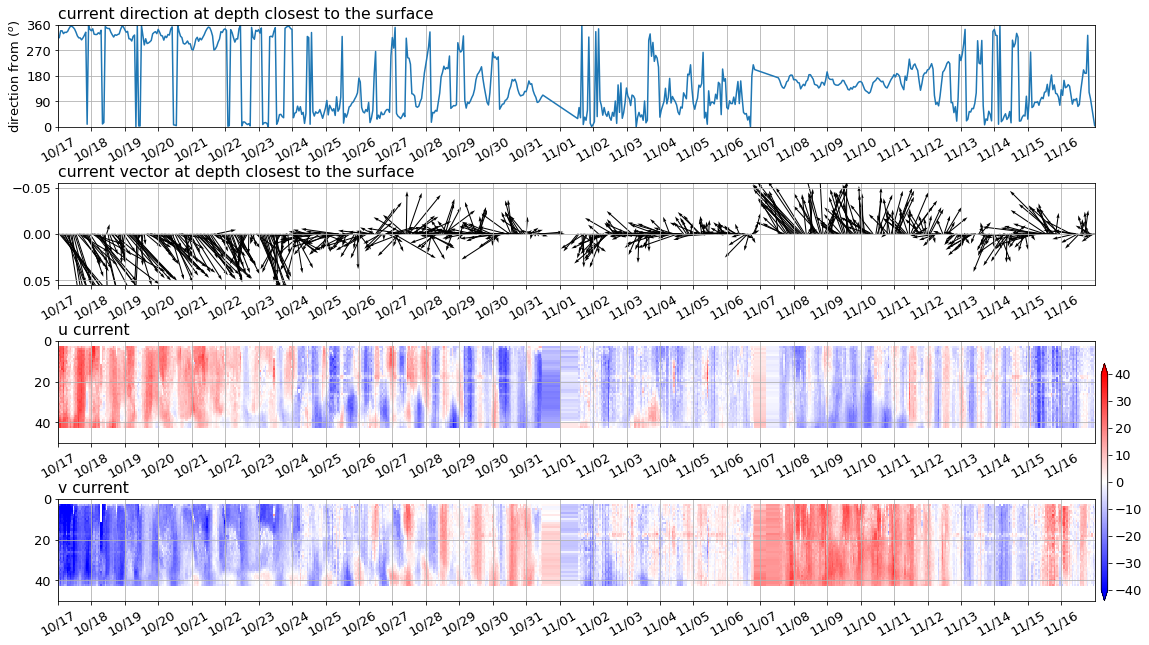

In [7]:
### plot current velocity time-depth contour plot
vellim = [-40,40]
cmap = 'bwr'
nrow = 4
itcur = np.where( (dtimeCur>= tlim_plot[0]) & (dtimeCur< tlim_plot[1]) )[0]
iz = np.argmin( depths_cur ) ### depth indice to plot
### plot
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 10)
plt.rcParams.update({'font.size': 13})
### current direction from (meteorological convention) at the depth closest the surface
plt.subplot(nrow,1,1)
plt.plot(dtimeCur[itcur],(arrayCur[itcur,iz]+180)%360)
plt.ylim([0,360]); plt.yticks(np.arange(0,450,90))
plt.ylabel('direction from ($^o$)')
plt.title('current direction at depth closest to the surface',loc='left')
### quiver plot at the depth closest the surface
plt.subplot(nrow,1,2)
plt.quiver(dtimeCur[itcur],np.zeros((len(itcur),)),uCur[itcur,iz],vCur[itcur,iz],scale=500,width=0.001)
plt.title('current vector at depth closest to the surface',loc='left')
### u
plt.subplot(nrow,1,3)
cs = plt.pcolormesh(dtimeCur[itcur], depths_cur, uCur[itcur,:].transpose(),label='u',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
plt.title('u current',loc='left')
cbar_ax = fig.add_axes([.905,.1,.005,.33])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
### v
plt.subplot(nrow,1,4)
plt.pcolormesh(dtimeCur[itcur], depths_cur, vCur[itcur,:].transpose(),label='v',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
plt.title('v current',loc='left')
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    if i > 1:
        plt.ylim([0,50])
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    if i > 0:
        plt.gca().invert_yaxis()
    plt.grid()
    
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.55)
### save figure
plt.savefig('timeseries_current_ncbc-'+buoy_id+'_'+tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')\
            +'.png',dpi=300,bbox_inches='tight')

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1865/3599650254.py:14: RuntimeWarning: invalid value encountered in remainder
  wind_dir_to = (np.array( arrayMet[:,5] )-180)%360
/Users/chi/opt/anaconda3/envs/pycode/lib/python3.9/site-packages/matplotlib/lines.py:1204: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
/Users/chi/opt/anaconda3/envs/pycode/lib/python3.9/site-packages/matplotlib/axis.py:125: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labelcolor == 'inherit':


<Figure size 432x288 with 0 Axes>

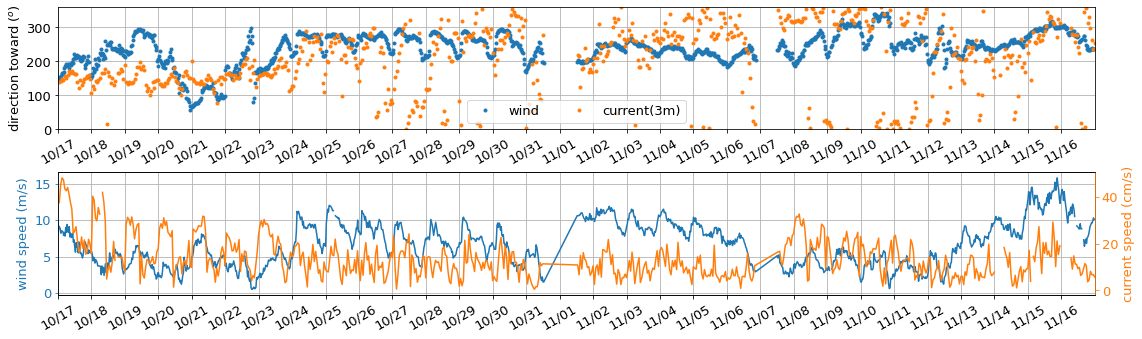

In [8]:
### over lay wind direction & near surface current direction (to)
nrow = 2
iz = np.where( depths_cur == 3 )[0] # depth indices plotted here
cmap = matplotlib.colormaps['tab10']
colors = cmap([0,0.1])
###
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
### plot direction
plt.subplot(nrow,1,1)
### wind direction
wind_dir_to = (np.array( arrayMet[:,5] )-180)%360
plt.plot( dtimeMet[itmet], wind_dir_to[itmet],'.',label='wind' )
### current direction
plt.plot( dtimeCur[itcur], arrayCur[itcur,i0dir+iz*3],'.',label='current('+str(int(depths_cur[iz]))+'m)')
plt.ylabel('direction toward ($^o$)')
plt.ylim([0,360])

### plot speed
plt.subplot(nrow,1,2)
y = np.sqrt( np.square(uwnd[itmet]) + np.square(vwnd[itmet]) )
ax[1].plot( dtimeMet[itmet],y,label='wind (m/s)',color=colors[0] )
ax[1].set_ylabel('wind speed (m/s)')
y = np.sqrt( np.square(uCur[itcur,iz]) + np.square(vCur[itcur,iz]) )
ax2 = ax[1].twinx()
ax2.plot( dtimeCur[itcur],y, label='current('+str(int(depths_cur[iz]))+'m) (cm/s)',color=colors[1])
ax2.set_ylabel('current speed (cm/s)')
### set colors for the twinxes
ax[1].yaxis.label.set_color(colors[0])
ax[1].spines["left"].set_edgecolor(colors[0])
ax[1].tick_params(axis='y', colors=colors[0])
ax2.yaxis.label.set_color(colors[1])
ax2.spines["right"].set_edgecolor(colors[1])
ax2.tick_params(axis='y', colors=colors[1])

### figure settings
for i in range( nrow ):
    ax[i].set_xticks(tticks,labels=tticks_label,rotation=30)
    ax[i].set_xlim(tlim_plot)
    ax[i].grid()
    if i == 0:
        ax[i].legend(ncol=2)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
### save figure
plt.savefig('timeseries_overlay_wind-current('+str(int(depths_cur[iz]))+'m)_ncbc-'+buoy_id+'_'+tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')\
            +'.png',dpi=300,bbox_inches='tight')

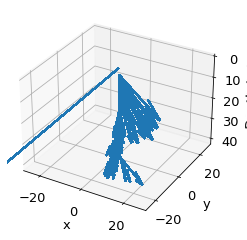

In [9]:
### plot wind vector on top of current velocity vectors with depth
ax = plt.figure().add_subplot(projection='3d')
# Make the grid
itcur_pick = np.where( dtimeCur== datetime.datetime(int(year),10,18,0,57) )[0]
itmet_pick = np.where( dtimeMet== datetime.datetime(int(year),10,18,1,5) )[0]
x, y, z = np.meshgrid( np.ones((len(depths_cur)+1,)), np.ones((len(depths_cur)+1,)), np.append(depths_cur,0) )
### units both in cm/s
u = np.append( np.squeeze(uCur[itcur_pick,:]), np.array([uwnd[itmet_pick]])*100 )
v = np.append( np.squeeze(vCur[itcur_pick,:]), np.array([vwnd[itmet_pick]])*100 )
w = np.zeros( u.shape )

ax.quiver(x, y, z, u, v, w, length=1)
ax.axis('equal')
# ax.set_xticklabels(''); ax.set_yticklabels('')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Depth (m)')
# ax.view_init(20,10)
ax.invert_zaxis()
plt.show()